In [1]:
setwd("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution")

In [2]:
source("qtls/liver_cells/input/packages.R"      )
source("qtls/liver_cells/input/input_files.R"   )
source("qtls/liver_cells/input/functions.R"     )
source("qtls/liver_cells/input/input_data.R"    )
source("qtls/liver_cells/input/load_metadata.R" )


Loading packages...
Loading input files...
Loading functions...
Loading input data...


In [33]:
suppressPackageStartupMessages(library(dplyr))


In [3]:
invisible(suppressWarnings(file.link("/home/matteo/notebooks/eqtls_deconvolution_gtex/permute_covariates_analysis.ipynb"    , "analysis/permute_covariates_analysis.ipynb"    )))


In [24]:
qtls = fread("analysis//egenes.liver_cells.txt", header = TRUE, sep = "\t", data.table = FALSE)
qtls$abs_beta = abs(qtls$beta)
qtls$logp     = -log10(qtls$bonferroni)
#qtls = qtls[ qtls$egene == TRUE, ]

In [60]:
read_perm = function(perm)
{
    indata = fread(paste("perm/qtls", paste("qtls", perm, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
    return(indata)
}

perms = as.data.frame(rbindlist(lapply(1:1000, read_perm)))
perms$abs_beta = abs(perms$beta)
perms$logp     = -log10(perms$bonferroni)
perms$egene    = FALSE
perms[perms$fdr < 0.1, "egene"] = TRUE

In [61]:
perms_av = perms[, c("gene_id", "logp", "abs_beta", "se")] %>% group_by(gene_id) %>% summarise_each(mean)
perms_av = as.data.frame(perms_av[perms_av$gene_id %in% qtls[qtls$egene == TRUE, "gene_id"],])

[[1]]
[[1]]$x
[1] "-log10(p-value)"

[[1]]$test

	Welch Two Sample t-test

data:  qtls[, x] and perms[, x]
t = 29.156, df = 15625, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.744665 1.996158
sample estimates:
mean of x mean of y 
 3.767921  1.897509 



[[2]]
[[2]]$x
[1] "Beta"

[[2]]$test

	Welch Two Sample t-test

data:  qtls[, x] and perms[, x]
t = -34.045, df = 15218, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4940004 -0.4402143
sample estimates:
mean of x mean of y 
 1.466488  1.933595 



[[3]]
[[3]]$x
[1] "Standard error of beta"

[[3]]$test

	Welch Two Sample t-test

data:  qtls[, x] and perms[, x]
t = -20.892, df = 15011, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.08196147 -0.06790126
sample estimates:
mean of x mean of y 
0.3686793 0.4436106 




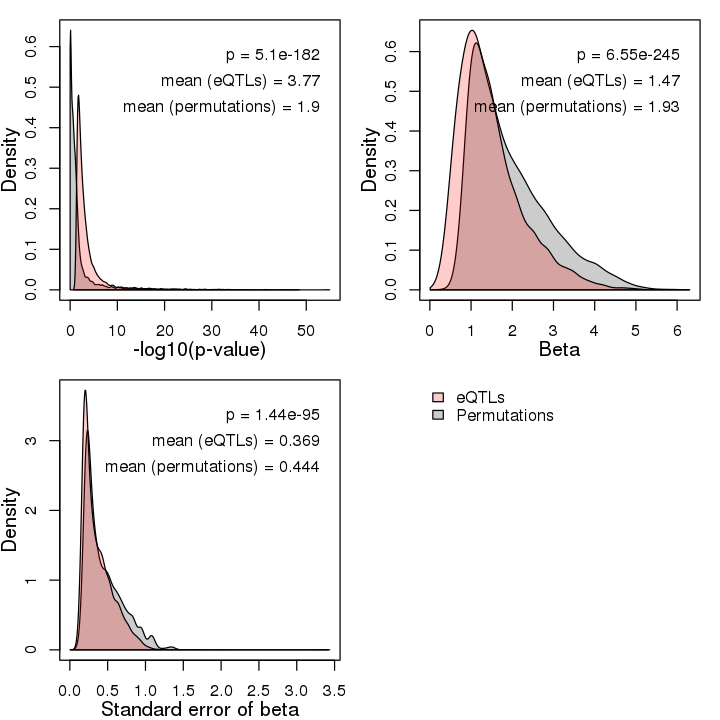

In [62]:
density_lines = function(x)
{
    dens = density(x)
    dens = data.frame(x = dens$x, y = dens$y)
    dens = dens[dens$x >= 0,]
    dens = rbind(dens, data.frame(x = c(max(dens$x), min(dens$x)), y = c(0,0)))
    #dens = rbind(dens, data.frame(x = rev(xlim), y = c(0,0)))
    
    return(dens)
}

polygon_density = function(dens, color, y0, yscale = 0.95)
{
    polygon(dens$x, (dens$y / max(dens$y) * yscale) + y0, col = color)
}

test_diffs = function(qtls, perms, x)
{
    test = t.test(qtls[, x], perms[, x])
    
    dens_qtls = density_lines(qtls [, x])
    dens_perm = density_lines(perms[, x])
    
    tox = ""
    
    if(x == "logp"    ){tox = "-log10(p-value)"       }
    if(x == "abs_beta"){tox = "Beta"                  }
    if(x == "se"      ){tox = "Standard error of beta"}
    
    ymax = max(c(max(dens_qtls$y), max(dens_perm$y)))
    x1   = min(c(min(dens_qtls$x), min(dens_perm$x)))
    x2   = max(c(max(dens_qtls$x), max(dens_perm$x)))
    
    par(mar = c(3,3,1,1))
    plot(1,1, type = "n", xlim = c(x1, x2), ylim = c(0, ymax), xlab = "", ylab = "")
    mtext(text = tox      , side = 1, line = 2)
    mtext(text = "Density", side = 2, line = 2)
    
    polygon(dens_perm$x, dens_perm$y, col = "#00000033")
    polygon(dens_qtls$x, dens_qtls$y, col = "#ff000033")
    
    text(x = x2, y = ymax * 0.1 * (9:7), pos = 2, labels = c(paste("p"                  , signif(test$p.value      , digits = 3), sep = " = "), 
                                                             paste("mean (eQTLs)"       , signif(test$estimate[[1]], digits = 3), sep = " = "), 
                                                             paste("mean (permutations)", signif(test$estimate[[2]], digits = 3), sep = " = ")))
    
    return(list(x = tox, test = test))
}

#test_diffs(qtls, perms, "abs_beta")

options(repr.plot.width=6, repr.plot.height=6)
layout(rbind(c(1,2), c(3,4)))
lapply(c("logp", "abs_beta", "se"), function(x){test_diffs(qtls[qtls$egene == TRUE,], perms_av, x)})

plot.new()
legend("topleft", legend = c("eQTLs", "Permutations"), fill = c("#ff000033", "#00000033"), box.lwd = 0)

In [63]:
pvals = aggregate(egene ~ perm, data = perms, FUN = sum)

In [65]:
summary(pvals)

      perm            egene     
 Min.   :   1.0   Min.   :1434  
 1st Qu.: 250.8   1st Qu.:1461  
 Median : 500.5   Median :1471  
 Mean   : 500.5   Mean   :1474  
 3rd Qu.: 750.2   3rd Qu.:1485  
 Max.   :1000.0   Max.   :1565  